# Step 4: Processing Bayesian inference and semi-empirical calibration results

The results from the previous McMC run are processed in more detail here.
 - The parameter chain values for each parameter (with the iteration as x-axis).
 - Kernel Density Estimate using samples of chain (considering number of burn-in samples). This estimates the posterior PDF from its samples.
 - TF (data, model initial guess, model best guess).

Other valuable visualisations exist and are implemented either in the ParaMonte, Arviz, etc. Pyton packages, such as the auto-correlation function (the correlation between samples).

In [70]:
# Import required packages.
# - Plot figures inline with text in this notebook.
%matplotlib inline
# - Higher DPI figures.
%config InlineBackend.figure_format='retina'
import os
import pickle
import numpy as np
import pandas as pd
import Source.BerghTijdemanWhitmoreModels as tt_m  # Analytical models.
from Source.ProcessingFunctions import frequency_response  # Complex TF to amplitude and phase of TF.
from Source.PlottingFunctions import plot_transfer_function_df, plot_chain_df, plot_kde_df

The output of the McMC run in *Step3_semi_empirical_calibration.ipynb* is saved in a file.
The variable names provided in that previous notebook, i.e., 'alpha' and 'vv_vt', are also not the labels that one wishes to use for plotting.
Hence, the following two inputs.

In [71]:
# File containing McMC samples.
F_MCMC = os.path.join('.', 'Media', 'McMC_results.pickle')

# For plotting. Converts parameter labels strings defined in McMC sample file into strings used for figures.
dct_par_labels = {'alpha': r'$|\alpha| \omega^{-1/2}$, s$^{1/2}$', 'vv_vt': r'$V_v/V_t$, -'}

In [72]:
# Load McMC data.
with open(F_MCMC, 'rb') as handle:
    dct_mcmc = pickle.load(handle)

df_d = dct_mcmc['DATA']  # Measurement data.
alpha_chain = dct_mcmc['alpha_chain']  # Parameter sample chain.
log_posterior_chain = dct_mcmc['rho_chain']  # Posterior logarithmic PDF of all the samples.

# Save the array of parameter values into a Pandas DataFrame.
df_chain = pd.DataFrame(alpha_chain, columns=dct_mcmc['MCMC_SETTINGS']['PAR_STR'])
df_chain.columns = [dct_par_labels[key_i] for key_i in df_chain.columns]

f_arr = df_d.index.to_numpy(float)  # Frequencies used for model.
norm_param = dct_mcmc['MCMC_SETTINGS']['ALPHA_FULL']  # Full array of initial parameter values.
gamma, pr = dct_mcmc['CONDITIONS']['GAMMA'], dct_mcmc['CONDITIONS']['PR']  # Model conditions.

The two relevant sets of parameter values are:
1. The initial guess parameters.
2. The best guess parameters, also known as the **maximum a posteriori (MAP)**.

In [73]:
# Initial guess fitting parameters.
alpha_0 = norm_param[1:]
# Best fitting parameters (MAP: Maximum A Posteriori).
alpha_map = alpha_chain[np.argmax(log_posterior_chain), :]

## 1. Transfer function

Simply plotting the TF is the first, and possibly most important, visualisation of the McMC. The data is a TF, the model returns TFs, and the aim is to get a good match between both. This match can be observed by the operator by simply plotting all the TFs.

In [74]:
# Define the model again, to run the initial and optimal guess parameters through.
def model(alpha_i, w=2*np.pi*f_arr):
    el_pin = tt_m.Element(k_l_pre=norm_param[0], alpha_pre=alpha_i[0]*1j**1.5, vv_vt=alpha_i[1], gamma=gamma, pr=pr)
    pr_pin = el_pin(w=w)
    return frequency_response(pr_pin)

For plotting, the TF associated to the initial guess parameters and best guess parameters (MAP) need to be computed.

E:\Thesis\SemiEmpiricalCalibrationBayesian\Source\BerghTijdemanWhitmoreModels.py:223: RuntimeWarning: divide by zero encountered in true_divide
  return k_l_j * np.sqrt(gamma / (n_j * j_2_j_0(alpha_j)))
E:\Thesis\SemiEmpiricalCalibrationBayesian\Source\BerghTijdemanWhitmoreModels.py:223: RuntimeWarning: invalid value encountered in true_divide
  return k_l_j * np.sqrt(gamma / (n_j * j_2_j_0(alpha_j)))
E:\Thesis\SemiEmpiricalCalibrationBayesian\Source\BerghTijdemanWhitmoreModels.py:223: RuntimeWarning: invalid value encountered in multiply
  return k_l_j * np.sqrt(gamma / (n_j * j_2_j_0(alpha_j)))
E:\Thesis\SemiEmpiricalCalibrationBayesian\Source\BerghTijdemanWhitmoreModels.py:165: RuntimeWarning: invalid value encountered in true_divide
  return 1 / (np.cosh(phi_l_j) + ve_vt_j * phi_l_j * np.sinh(phi_l_j))
E:\Thesis\SemiEmpiricalCalibrationBayesian\Source\PlottingFunctions.py:285: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI b

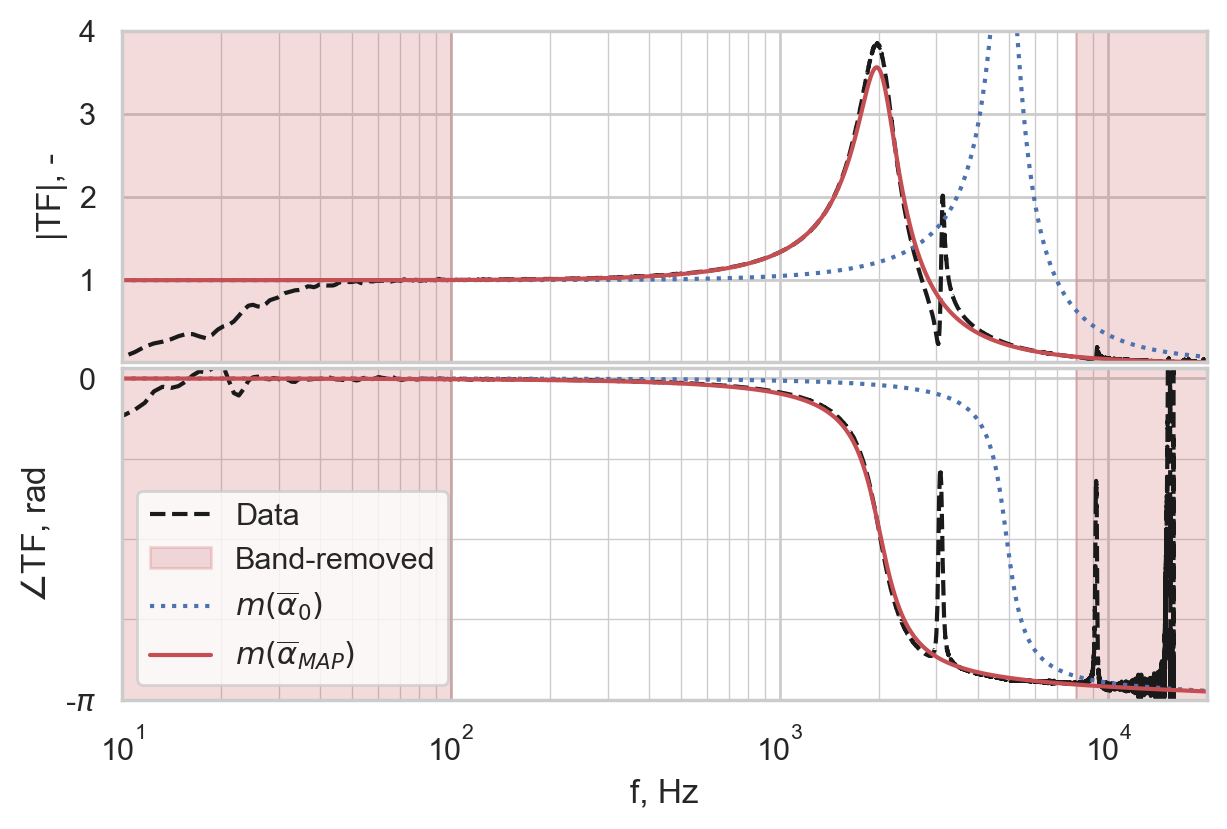

In [75]:
# Model TFs.
amp_m_0, phase_m_0 = model(alpha_i=alpha_0)  # Initial guess.
# Best fitting parameters (MAP: Maximum A Posteriori).
amp_m_map, phase_m_map = model(alpha_i=alpha_map)  # Amplitude and phase of TF.

# Plotting.
fig_tf, ax_tf = plot_transfer_function_df(
    df=df_d, fig_dim=(6, 4), color='k', linestyle='--', alpha=1., legend_loc='lower left',
    minor_phase=0.25, x_lim=(1E1, 2E4), y_lim_amp=(1E-2, 4E0), y_lim_phase=(-1 * np.pi, 0.1))
# Plot band-removed data.
f_band_remove_lst = dct_mcmc['MCMC_SETTINGS']['F_BAND_REMOVE_LST']
for ax_i in ax_tf.flatten():
    y_lim_i = ax_i.get_ylim()
    for (x_lower_limit_i, x_upper_limit_i) in f_band_remove_lst[:-1]:
        ax_i.fill_betweenx(y=y_lim_i, x1=2 * [x_lower_limit_i], x2=2 * [x_upper_limit_i],
                           color='r', alpha=0.2)
    ax_i.fill_betweenx(y=y_lim_i, x1=2 * [f_band_remove_lst[-1][0]], x2=2 * [f_band_remove_lst[-1][1]],
                       color='r', alpha=0.2, label='Band-removed')
# Model TFs.
ax_tf[0].plot(f_arr, amp_m_0, color='b', linestyle=':', label=r'$m(\overline{\alpha}_0)$')  # Initial guess.
ax_tf[1].plot(f_arr, phase_m_0, color='b', linestyle=':', label=r'$m(\overline{\alpha}_0)$')
ax_tf[0].plot(f_arr, amp_m_map, color='r', linestyle='-', label=r'$m(\overline{\alpha}_{MAP})$')  # Best guess.
ax_tf[1].plot(f_arr, phase_m_map, color='r', linestyle='-', label=r'$m(\overline{\alpha}_{MAP})$')
ax_tf[1].legend(loc='lower left')
fig_tf.tight_layout(pad=0.1)  # Tries to fill white-space in figure.

## 2. Chain parameter value evolution

The evolution of the parameter values is another interesting metric. As mentioned before, the chain will evolve from the initial guess to a high probability region (close to the MAP), this process is termed 'burn-in'. These burn-in samples are not representative of the posterior PDF, and should therefore not be used in the next visualisation: the Kernel Density Estimate (KDE).

E:\Thesis\SemiEmpiricalCalibrationBayesian\Source\PlottingFunctions.py:387: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_chain.show()  # Show the figure.


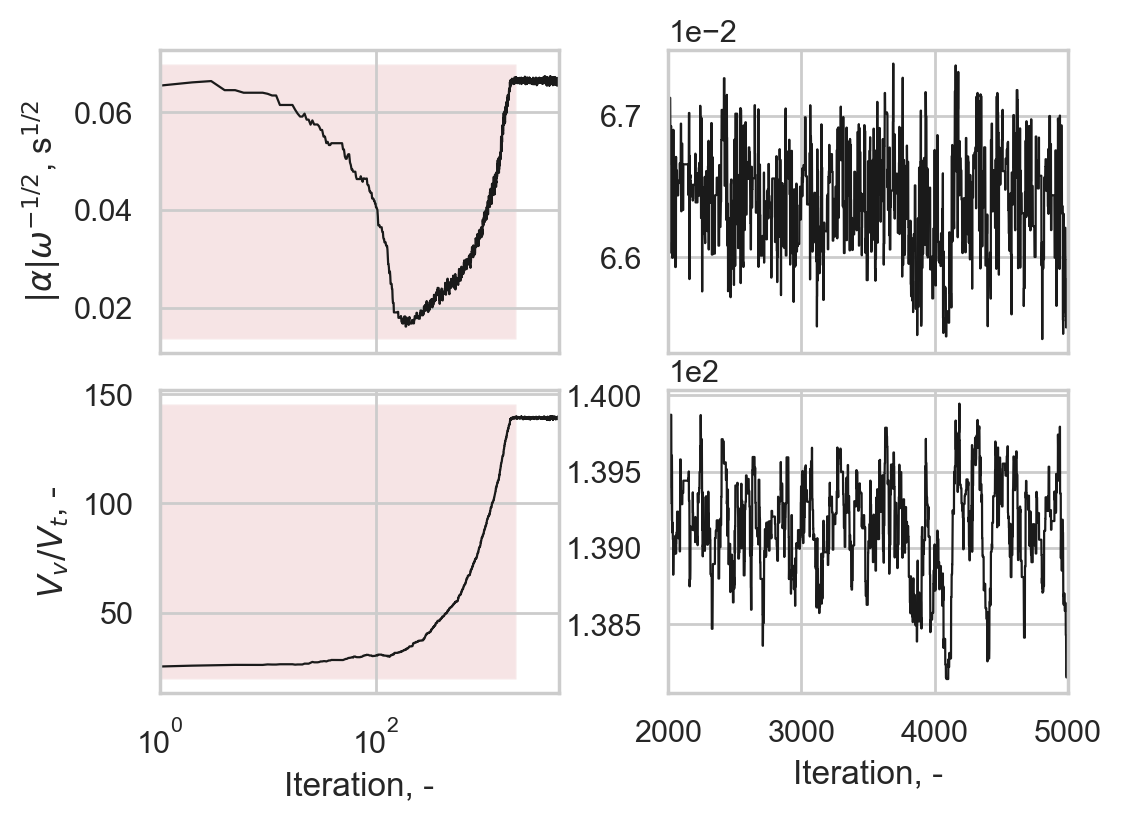

In [76]:
N_BURN_IN = 2000
LOG_MODE = True
fig_chain, ax_chain = plot_chain_df(df=df_chain, n_burn_in=N_BURN_IN, log_mode=LOG_MODE)
[ax_i.grid() for ax_i in ax_chain.flatten()];
fig_chain.tight_layout(pad=0.2)

## 3. Kernel Density Estimate

Lastly, the Kernel Density Estimate (KDE) is a way to use samples, taken according to a PDF, to estimate the underlying PDF. In the case of McMC, the samples are taken based on the value of the posterior at those parameter values. Hence, this is a perfect fit for McMC. The local density of the samples is proportional to the local PDF value. It works similar to a histogram, where the height of the bins estimates the PDF, but in a smoothened manner.

C:\Users\Olivier\AppData\Local\Temp\ipykernel_9308\957131024.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g_kde.fig.show()


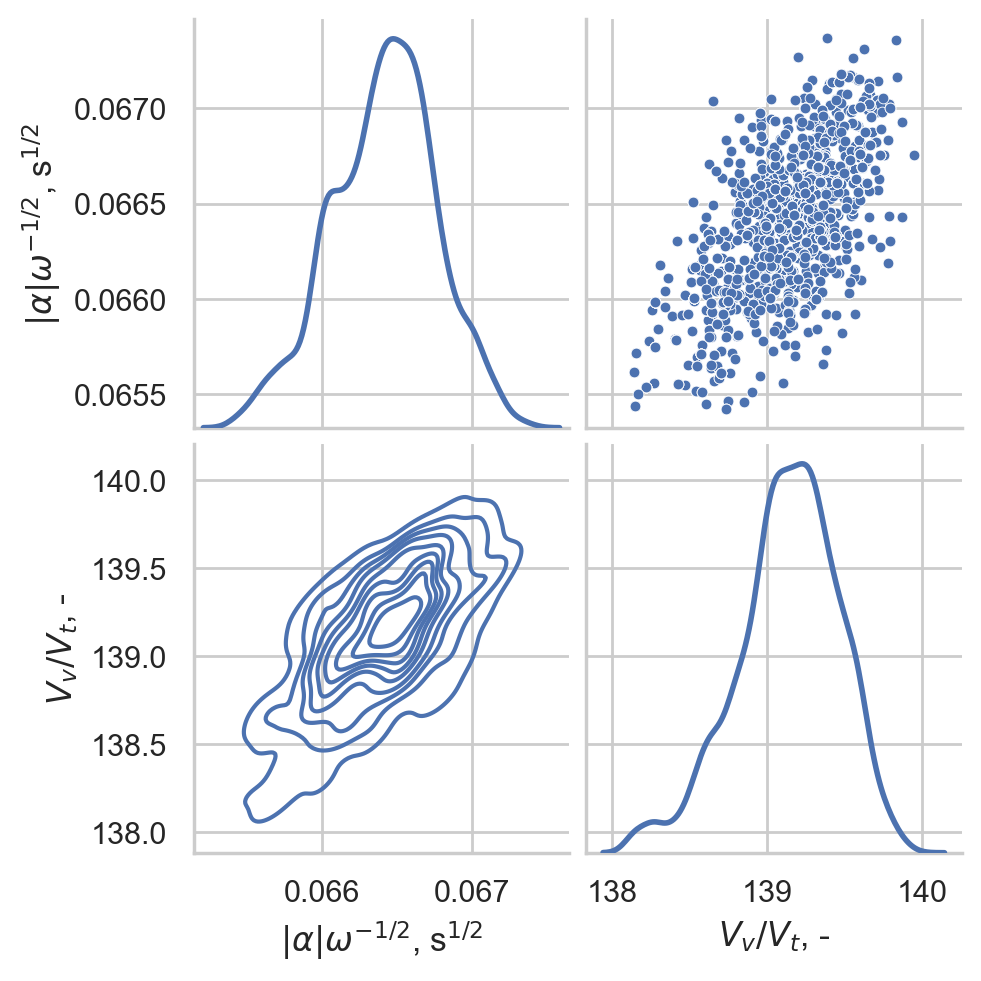

In [77]:
g_kde = plot_kde_df(
    df=df_chain.iloc[N_BURN_IN:, :],
    kwargs_for_pair_grid=None, kwargs_for_seaborn_theme={'style': 'whitegrid'})
g_kde.tight_layout()
g_kde.fig.show()